**Initial Data Retrival and Cleaning**

In [1]:
import yfinance as yf
import pandas as pd

# Get data on this ticker (oil to start with)
tickerDF = yf.Ticker('CL=F')

# Get the historical prices for this ticker
tickerDF = tickerDF.history(period='max')

#displaying oil index
tickerDF.index

DatetimeIndex(['2000-08-23 00:00:00-04:00', '2000-08-24 00:00:00-04:00',
               '2000-08-25 00:00:00-04:00', '2000-08-28 00:00:00-04:00',
               '2000-08-29 00:00:00-04:00', '2000-08-30 00:00:00-04:00',
               '2000-08-31 00:00:00-04:00', '2000-09-01 00:00:00-04:00',
               '2000-09-05 00:00:00-04:00', '2000-09-06 00:00:00-04:00',
               ...
               '2024-03-22 00:00:00-04:00', '2024-03-25 00:00:00-04:00',
               '2024-03-26 00:00:00-04:00', '2024-03-27 00:00:00-04:00',
               '2024-03-28 00:00:00-04:00', '2024-04-01 00:00:00-04:00',
               '2024-04-02 00:00:00-04:00', '2024-04-03 00:00:00-04:00',
               '2024-04-04 00:00:00-04:00', '2024-04-05 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=5930, freq=None)

<Axes: xlabel='Date'>

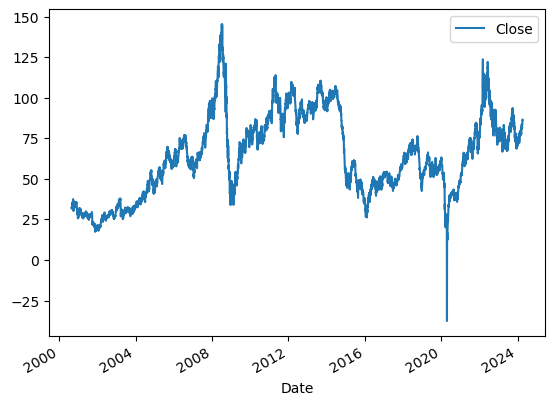

In [2]:
# plotting oil index
tickerDF.plot.line(y="Close", use_index=True)

In [3]:
# removing unneeded columns
del tickerDF["Dividends"]
del tickerDF["Stock Splits"]

In [4]:
# adds column that will be tomorrow's price 
#(the particular stocks price the following day)
tickerDF["Tomorrow"] = tickerDF["Close"].shift(-1)

In [5]:
#sets a target that indicates is what we will aim to predict. 
#Returns an int for ML use
#returns 1 when price goes up
#returns 0 when price goes down
tickerDF["Target"] = (tickerDF["Tomorrow"] > tickerDF["Close"]).astype(int)

In [6]:
#removing all data that comes before 1990
tickerDF = tickerDF.loc["1990-01-01":].copy()

**Initial ML Model**

In [7]:
from sklearn.ensemble import RandomForestClassifier

#random forest works by training a set of indiv decision trees
##with randomised parameters
###it then averages the results to resist overfitting and
####can pick up non-linear relationships (most of this data)

#100 initial trees to test
##100 min samples to protect against overfitting
###(higher = less overfitting but less model acuracy)
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

#splitting data into train and test set
##time-series data can't use cross-validation to split data. Results in leakage
train = tickerDF.iloc[:-100]
test= tickerDF.iloc[-100:]

#simple baseline model for now
#careful not to use tomorrow column
predictors = ["Close", "Volume", "Open", "High", "Low"]

#train model using predictor columns in order to predict target
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [8]:
#meausure model accuracy
# what percentage of time did the model claim prices would go up and actually did
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

#changing to panda series
preds = pd.Series(preds, index=test.index)

In [9]:
#calculating precision_score using actual Target and predicted target
precision_score(test["Target"], preds)

0.4657534246575342

<Axes: xlabel='Date'>

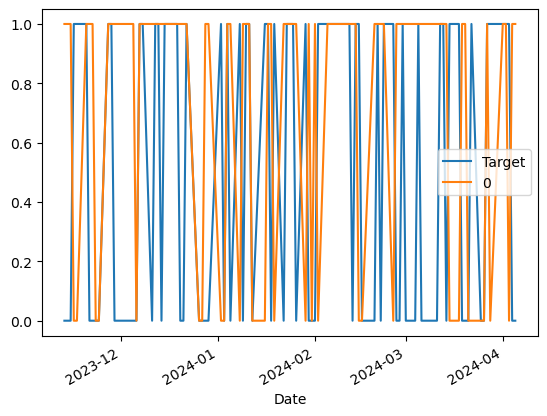

In [10]:
#plot predictions 
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

Backtesting System

In [11]:
# function which brings all of the above together
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [12]:
#each trading year has roughly 250 trading days
#trains model for year before moving on
#trains for 10 years then predicts for 11th year

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [13]:
predictions = backtest(tickerDF, model, predictors)

In [14]:
# 1 is times price went up as predicted
predictions["Predictions"].value_counts()

Predictions
1    2091
0    1339
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.523194643711143

In [16]:
#market went up ~51% of the time as predicted

#benchmark of days market actually went up
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.525073
0    0.474927
Name: count, dtype: float64

In [17]:
#algorithm performed worse than if picking randomly

In [18]:
# rolling averages
# mean close price in last 2 days, trading week, 3 months , last year , last 4 years
# find ratio between today's closing price and the closing price in these periods
horizons = [2,5,60,250,1000]

new_predictors = []

#loops through each average 
for horizon in horizons:
    rolling_averages = tickerDF.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    tickerDF[ratio_column] = tickerDF["Close"] / rolling_averages["Close"]
    
    # number of days stock price went up
    trend_column = f"Trend_{horizon}"
    tickerDF[trend_column] = tickerDF.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

tickerDF = tickerDF.dropna(subset=tickerDF.columns[tickerDF.columns != "Tomorrow"])

In [19]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [20]:
#reduce total number of trading days
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [21]:
predictions = backtest(tickerDF, model, new_predictors)

In [22]:
predictions["Predictions"].value_counts()

Predictions
0.0    2194
1.0     236
Name: count, dtype: int64

In [23]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4661016949152542

In [24]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.52716
0    0.47284
Name: count, dtype: float64

In [25]:
predictions

,Target,Predictions
Date,,
2014-08-08 00:00:00-04:00,1,0.0
2014-08-11 00:00:00-04:00,0,0.0
2014-08-12 00:00:00-04:00,1,0.0
2014-08-13 00:00:00-04:00,0,0.0
2014-08-14 00:00:00-04:00,1,0.0
...,...,...
2024-04-01 00:00:00-04:00,1,0.0
2024-04-02 00:00:00-04:00,1,0.0
2024-04-03 00:00:00-04:00,1,0.0


In [26]:
def predict_direction(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    # Determine if the majority of predictions indicate price going up or down
    if preds.mean() > 0.5:
        return "Up"
    else:
        return "Down"

# Example usage
next_day_price = predict_direction(train, test, predictors, model)
print("Tomorrow's Oil price direction:", next_day_price)

import pickle    
#with open(r'C:\Users\jackc\Documents\FYP_ML_Predict\models\RFC_Oil.pkl', 'wb') as pkl:
 #   pickle.dump(next_day_price, pkl)

with open(r'C:\Users\15105006\Desktop\ML_Project\models\RFC_Oil.pkl', 'wb') as pkl:
    pickle.dump(next_day_price, pkl)

Tomorrow's Oil price direction: Up
